# CNN

## 1. Imports

### 1.1 Setup for Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
 cd /content/drive/MyDrive/data

/content/drive/MyDrive/data


In [7]:
ls

backup_removed_files/        RGB/     Thermal/     wandb/
CNN_Final_EarlyFusion.ipynb  RgbAug/  ThermalAug/


### 1.2 Install Depedencies

In [ ]:
#install dependencies
# !pip install -r requirements.txt

In [8]:
import os
import copy
import glob
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tqdm import tqdm
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms,models
from torchvision.models import shufflenet_v2_x1_0, ShuffleNet_V2_X1_0_Weights
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import pandas as pd
import wandb

### 1.2 Global Variables

In [9]:
EPOCHS = 5
CLASSES = 7
BATCH_SIZE = 64
NUM_WORKERS = 4 # change based on specification of computer
LEARNING_RATE = 0.001

In [10]:
wandb.init(
    project="multimodal_shuffle_cnn",
    name="early_fusion_cnn",
    config={
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "learning_rate": LEARNING_RATE,
        "model": "CNN Early Fusion",
        "fusion_type": "att"
    }
)

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: reicraftscodes (reicraftscodes-university-of-the-west-of-england) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## 2. Load Data and Split

In [11]:
#directories
rgbDir = ['RGB','RgbAug']
thermalDir = ['Thermal','ThermalAug']

### 2.1 Single Modality

In [12]:
def loadDataSingleModality(modalDir):
    '''
    Loads and processes data from a single modality (either RGB or Thermal).
    Args:
        modalDir (list): List containing two directory paths - first for raw images, second for augmented images.
    Returns:
        pairedFiles (list): List of all image file paths.
        tensorLabels (torch.Tensor): Tensor of integer-encoded labels corresponding to the images.
    '''

    #get list of files in the directory and combine them
    pairedFiles = []
    for data in modalDir:
        pairedFiles.extend(glob.glob(os.path.join(data, "*")))
    pairedFiles = sorted(pairedFiles)

    print(f'Total files: {len(pairedFiles)}')


    #get the labels from the filenames
    SMLabels = [os.path.basename(f).split('_')[1] for f in pairedFiles] #1 = emotion label

    #convert labels to integer
    le = preprocessing.LabelEncoder()
    intLabels = le.fit_transform(SMLabels)
    #convert targets to tensor
    tensorLabels = torch.as_tensor(intLabels)
    #class names
    classNames = le.classes_

    print(f'Data arranged as: {tensorLabels}')
    print(f'\nSample output:\nFile: {pairedFiles[0]}\nLabel: {SMLabels[0]}\n')

    return pairedFiles, tensorLabels, classNames


## For single modality testing (using raw and augmented data together)

#change this to test either thermal or rgb
modalDir = rgbDir

#Call function to load data
pairedFiles, tensorLabels, classNames = loadDataSingleModality(modalDir)

#for saving results later
if modalDir == rgbDir:
    savingLabel = "RGB"
else:
    savingLabel = "Thermal"

Total files: 20675
Data arranged as: tensor([0, 0, 0,  ..., 6, 6, 6])

Sample output:
File: RGB/R_Angry_10_KTFE.jpg
Label: Angry



### 2.2 Multi Modality

In [13]:
def loadDataMultiModality(rgbDir,thermalDir):
    '''
    Loads and processes data from both RGB and Thermal modalities.
    Args:
        rgbDir (list): List containing two directory paths for RGB images - first for raw images, second for augmented images.
        thermalDir (list): List containing two directory paths for Thermal images - first for raw images, second for augmented images.
    Returns:
        pairedFiles (list): List of tuples, each containing a pair of (RGB image path, Thermal image path).
        tensorLabels (torch.Tensor): Tensor of integer-encoded labels corresponding to the images.
    '''


    #get list of files in the directory and combine them
    rgbFiles = []
    thermalFiles = []
    for data in rgbDir:
        rgbFiles.extend(glob.glob(os.path.join(data, "*")))
    for data in thermalDir:
        thermalFiles.extend(glob.glob(os.path.join(data, "*")))

    #pairs thermal and rgb files together
    pairedFiles = list(zip(rgbFiles, thermalFiles))
    print(f"Total pairs: {len(pairedFiles)}")

    #get the labels from the filenames
    SMLabels = [os.path.basename(f).split('_')[1] for f in thermalFiles] #1 = emotion label

    #convert labels to integer
    le = preprocessing.LabelEncoder()
    intLabels = le.fit_transform(SMLabels)

    #convert targets to tensor
    tensorLabels = torch.as_tensor(intLabels)

    #class names
    classNames = le.classes_

    print(f'Data arranged as: {tensorLabels}')
    print(f'\nSample output:\nFile: {pairedFiles[0]}\nLabel: {SMLabels[0]}\n')

    return pairedFiles, tensorLabels, classNames


## For multi modality testing (using raw and augmented data together)

#Call function to load data
pairedFiles, tensorLabels, classNames = loadDataMultiModality(rgbDir,thermalDir)


Total pairs: 20675
Data arranged as: tensor([5, 5, 5,  ..., 0, 0, 0])

Sample output:
File: ('RGB/R_Sad_2002_KTFE.jpg', 'Thermal/T_Sad_2117_KTFE.jpg')
Label: Sad



### 2.3 Split Data
- 80:20

In [14]:

#Split Data
X_train, X_test, y_train, y_test = train_test_split(
    pairedFiles, tensorLabels,
    test_size=0.2,
    stratify=tensorLabels,
    random_state=42
)
print(f'Train size: {len(X_train)}\nTest size: {len(X_test)}')

Train size: 16540
Test size: 4135


In [15]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

## 3. DataLoader

### 3.1 Single Modality

In [16]:
class SingleModalImageDataset(Dataset):
    def __init__(self, pairedFiles, labels, transform=None):
        #initialise
        self.pairedFiles = pairedFiles
        self.labels = labels
        self.transform = transform

    def __len__(self):
        #return the length of the dataset
        return len(self.pairedFiles)

    def __getitem__(self, idx):
        #generates samples
        imagePath = self.pairedFiles[idx]
        image = Image.open(imagePath).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label


train_dataset = SingleModalImageDataset(X_train, y_train, transform=transform)
test_dataset = SingleModalImageDataset(X_test, y_test, transform=transform)

### 3.2 Multi Modality

In [17]:
class MultiModalImageDataset(Dataset):
    def __init__(self, pairedFiles, labels, transform=None):
        #initialise
        self.pairedFiles = pairedFiles
        self.labels = labels
        self.transform = transform

    def __len__(self):
        #return the length of the dataset
        return len(self.pairedFiles)

    def __getitem__(self, idx):
        #generates samples
        rgbPath,thermalPath  = self.pairedFiles[idx]
        rgb = Image.open(rgbPath).convert('RGB')
        thermal = Image.open(thermalPath).convert('RGB') #try L greyscale

        if self.transform:
            rgb = self.transform(rgb)
            thermal = self.transform(thermal)

        label = self.labels[idx]
        return (rgb,thermal),label

train_dataset = MultiModalImageDataset(X_train, y_train, transform=transform)
test_dataset = MultiModalImageDataset(X_test, y_test, transform=transform)

### 3.3 Train and Test Loader

In [18]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,num_workers=NUM_WORKERS)

## 4. ShuffleNet V.2

### 4.1 Single Modality

In [ ]:
#device configuration
device = "cuda" if torch.cuda.is_available() else "cpu"

#initialise model
model = models.shufflenet_v2_x1_0(weights=ShuffleNet_V2_X1_0_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, CLASSES)
model.to(device)

#loss function and optimiser
criterion = torch.nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)

#to collect data for plotting later
trainLosses = []
testAccuracies = []
predictionsArr = []
targetsArr = []

##Training
for epoch in range(EPOCHS):
    model.train()
    runningTrain = 0
    #progress bar
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
        x, y = x.to(device), y.to(device)
        optimiser.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        optimiser.step()
        #batch loss calculation
        runningTrain += loss.item() * x.size(0)
    trainLoss = runningTrain / len(train_loader.dataset)

    ##Evaluation
    model.eval()
    accPre = 0
    totalDatapoints = 0
    #progress bar
    for input, target in tqdm(test_loader, desc=f"Epoch {epoch+1} Evaluating"):
        input, target = input.to(device), target.to(device)
        with torch.no_grad():
            outputs = model(input)
            #accuracy calculation
            predicted = outputs.argmax(1)

            #https://medium.com/@heyamit10/building-a-multiclass-classification-model-in-pytorch-a-detailed-practical-guide-b03fc93aa400
            predictionsArr.extend(predicted.cpu().numpy())
            targetsArr.extend(target.cpu().numpy())

            accPre += (predicted == target).sum().item()
            totalDatapoints += target.size(0)
    finalAcc = accPre / totalDatapoints

    trainLosses.append(trainLoss)
    testAccuracies.append(finalAcc)


    #prints each epoch's results
    print(f"Epoch {epoch+1}: Train Loss = {trainLoss:.4f}, Test Accuracy = {finalAcc:.4f}")


### 4.2 Multi Modality

In [19]:
class EarlyFusionFER(nn.Module):
    """
    Early Fusion CNN using concatenation fusion type
    """

    def __init__(self, num_classes: int = 7, fusion_type: str = "add"):
        """
        Args:
            num_classes: Number of emotion classes (7 for FER)
            fusion_type: How to fuse RGB and Thermal ("concat" or "add")
        """
        super().__init__()

        self.num_classes = num_classes
        self.fusion_type = fusion_type

        # Determine input channels
        if fusion_type == "concat":
            input_channels = 6
        else:  # add
            input_channels = 3

        # Load pre-trained ShuffleNet V2
        self.model = shufflenet_v2_x1_0(weights=ShuffleNet_V2_X1_0_Weights.DEFAULT)

        # Modify first conv layer for multimodal input
        if input_channels != 3:
            # Original first conv layer
            original_conv = self.model.conv1[0]

            new_conv = nn.Conv2d(
                # New number of input channels
                input_channels,
                # Keep original output channels
                original_conv.out_channels,
                # Same kernel size
                kernel_size=original_conv.kernel_size,
                stride=original_conv.stride,
                padding=original_conv.padding,
                bias=original_conv.bias is not None
            )

            # Initialise new conv weights
            with torch.no_grad():
                if input_channels == 6:  # concat case
                    new_conv.weight[:, :3, :, :] = original_conv.weight  # RGB channels
                    new_conv.weight[:, 3:6, :, :] = original_conv.weight  # Thermal channels

                if original_conv.bias is not None:
                    new_conv.bias.copy_(original_conv.bias)

            # Replace the first conv layer
            self.model.conv1[0] = new_conv

        # Replace the final classifier to match num_classes
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, rgb_images, thermal_images):
        """
        Forward pass

        Args:
            rgb_images: RGB images tensor (B, 3, H, W)
            thermal_images: Thermal images tensor (B, 3, H, W)

        Returns:
            Logits tensor (B, num_classes)
        """

        # Ensure both images are on the same device
        device = rgb_images.device
        thermal_images = thermal_images.to(device)

        # Fuse RGB and Thermal at input level
        if self.fusion_type == "concat":   # concat
            fused_input = torch.cat([rgb_images, thermal_images], dim=1)  # (B, 6, H, W) 6 channels
        else:  # add
            fused_input = rgb_images + thermal_images


        # Forward pass through ShuffleNet
        return self.model(fused_input) # Returns logits (B, num_classes)


# Device configuration
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialise multimodal model
model = EarlyFusionFER(num_classes=CLASSES, fusion_type="concat")
model.to(device)

# Loss function and optimiser
criterion = torch.nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# To collect data for plotting later
trainLosses = []
testAccuracies = []
predictionsArr = []
targetsArr = []

# For saving results
savingLabel = "MultiModal_EarlyFusion"

## Training
for epoch in range(EPOCHS):
    model.train()
    runningTrain = 0

    # Training loop
    for (rgb, thermal), y in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
        rgb, thermal, y = rgb.to(device), thermal.to(device), y.to(device)
        optimiser.zero_grad()

        # Forward pass
        outputs = model(rgb, thermal)
        loss = criterion(outputs, y)

        loss.backward()
        optimiser.step()

        # Accumulate batch loss
        runningTrain += loss.item() * rgb.size(0)

    # Calculate epoch training loss (once per epoch)
    trainLoss = runningTrain / len(train_loader.dataset)

    ## Evaluation
    model.eval()
    accPre = 0
    totalDatapoints = 0

    for (rgb, thermal), target in tqdm(test_loader, desc=f"Epoch {epoch+1} Evaluating"):
        rgb, thermal, target = rgb.to(device), thermal.to(device), target.to(device)
        with torch.no_grad():
            outputs = model(rgb, thermal)
            predicted = outputs.argmax(1)

            # Collect predictions and targets
            predictionsArr.extend(predicted.cpu().numpy())
            targetsArr.extend(target.cpu().numpy())

            accPre += (predicted == target).sum().item()
            totalDatapoints += target.size(0)

    finalAcc = accPre / totalDatapoints
    trainLosses.append(trainLoss)
    testAccuracies.append(finalAcc)

    # Combined wandb log (train loss, test accuracy, GPU usage)
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": trainLoss,
        "test_accuracy": finalAcc,
        "gpu_memory_allocated_GB": torch.cuda.memory_allocated() / 1e9,
        "gpu_memory_reserved_GB": torch.cuda.memory_reserved() / 1e9
    })

    # Print results
    print(f"Epoch {epoch+1}: Train Loss = {trainLoss:.4f}, Test Accuracy = {finalAcc:.4f}")

# Final results
print(f"\nFinal Results:")
print(f"Best Test Accuracy: {max(testAccuracies):.4f}")
print(f"Final Test Accuracy: {testAccuracies[-1]:.4f}")

wandb.finish()

Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth


100%|██████████| 8.79M/8.79M [00:00<00:00, 74.7MB/s]
Epoch 1 Evaluating: 100%|██████████| 65/65 [05:02<00:00,  4.66s/it]


Epoch 1: Train Loss = 0.9902, Test Accuracy = 0.7393


Epoch 2 Evaluating: 100%|██████████| 65/65 [00:16<00:00,  3.93it/s]


Epoch 2: Train Loss = 0.4396, Test Accuracy = 0.8152


Epoch 3 Evaluating: 100%|██████████| 65/65 [00:16<00:00,  3.88it/s]


Epoch 3: Train Loss = 0.2672, Test Accuracy = 0.7954


Epoch 4 Evaluating: 100%|██████████| 65/65 [00:16<00:00,  3.88it/s]


Epoch 4: Train Loss = 0.1848, Test Accuracy = 0.8948


Epoch 5 Evaluating: 100%|██████████| 65/65 [00:16<00:00,  3.96it/s]

Epoch 5: Train Loss = 0.1324, Test Accuracy = 0.8755

Final Results:
Best Test Accuracy: 0.8948
Final Test Accuracy: 0.8755


epoch,▁▃▅▆█
gpu_memory_allocated_GB,▁▁▁▁▁
gpu_memory_reserved_GB,▁▁▁▁▁
test_accuracy,▁▄▄█▇
train_loss,█▄▂▁▁
epoch,5
gpu_memory_allocated_GB,0.08507
gpu_memory_reserved_GB,1.7679
test_accuracy,0.87545
train_loss,0.13238


## 5. Visualise and Save Results

### 5.1 Save Metrics

In [20]:
saveResults = "trainingResults"
os.makedirs(saveResults, exist_ok=True)

#save training loss and accuracy to CSV
metrics = pd.DataFrame({'Epoch': range(1, len(trainLosses) + 1), 'Training Loss': trainLoss,'Test Accuracy': testAccuracies}) #create each row as epoch

#saves based on modality used
if savingLabel == "RGB":
  metrics.to_csv(os.path.join(saveResults, "metrics_RGB.csv"), index=False)
elif savingLabel == "Thermal":
  metrics.to_csv(os.path.join(saveResults, "metrics_Thermal.csv"), index=False)
else:
  metrics.to_csv(os.path.join(saveResults, "metrics_MultiModal_EarlyFusion.csv"), index=False)


### 5.2 Visualise Graphs

In [ ]:
#loss curve
plt.plot(range(1, len(trainLosses) + 1), trainLosses, marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
#saves based on modality used
if savingLabel == "RGB":
    plt.savefig(os.path.join(saveResults, "trainLoss_RGB.png"))
else:
    plt.savefig(os.path.join(saveResults, "trainLoss_Thermal.png"))
plt.show()

#accuracy
plt.plot(range(1, len(testAccuracies) + 1), testAccuracies, marker='o')
plt.title("Test Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid()
#saves based on modalžty used
if savingLabel == "RGB":
    plt.savefig(os.path.join(saveResults, "testAccuracy_RGB.png"))
else:
    plt.savefig(os.path.join(saveResults, "testAccuracy_Thermal.png"))
plt.show()

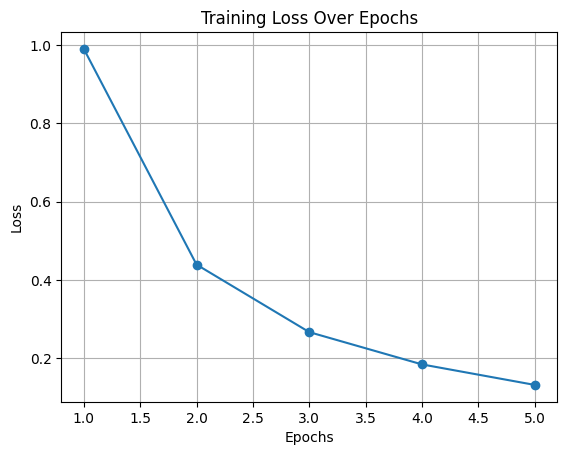

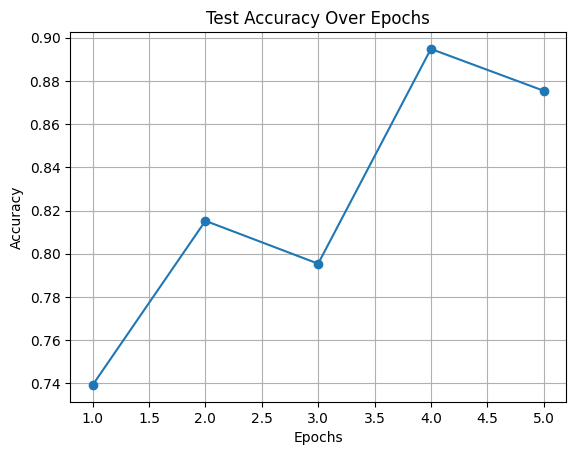

In [21]:
# MULTIMODAL
#loss curve
plt.plot(range(1, len(trainLosses) + 1), trainLosses, marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
#saves based on modality used
if savingLabel == "MultiModal_EarlyFusion":
    plt.savefig(os.path.join(saveResults, "trainLoss_MultiModal_EarlyFusion.png"))
plt.show()

#accuracy
plt.plot(range(1, len(testAccuracies) + 1), testAccuracies, marker='o')
plt.title("Test Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid()
#saves based on modalžty used
if savingLabel == "MultiModal_EarlyFusion":
    plt.savefig(os.path.join(saveResults, "testAccuracy_MultiModal_EarlyFusion.png"))
plt.show()

In [ ]:
#confusion matrix and classification report
conf_matrix = confusion_matrix(targetsArr, predictionsArr)

print("\nClassification Report:")
print(classification_report(targetsArr, predictionsArr))
#saves based on modality used
if savingLabel == "RGB":
    with open(os.path.join(saveResults, "classificationReport_RGB.txt"), "w") as f:
        f.write(classification_report(targetsArr, predictionsArr))
else:
    with open(os.path.join(saveResults, "classificationReport_Thermal.txt"), "w") as f:
        f.write(classification_report(targetsArr, predictionsArr))

#visualisation of confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=classNames, yticklabels=classNames)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
#saves based on modality used
if savingLabel == "RGB":
    plt.savefig(os.path.join(saveResults, "confusionMatrix_RGB.png"))
else:
    plt.savefig(os.path.join(saveResults, "confusionMatrix_Thermal.png"))
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.86      0.82      3895
           1       0.85      0.85      0.85      1105
           2       0.84      0.85      0.85      1730
           3       0.84      0.77      0.80      6030
           4       0.84      0.68      0.75       515
           5       0.83      0.96      0.89      4410
           6       0.82      0.69      0.75      2990

    accuracy                           0.82     20675
   macro avg       0.83      0.81      0.82     20675
weighted avg       0.82      0.82      0.82     20675



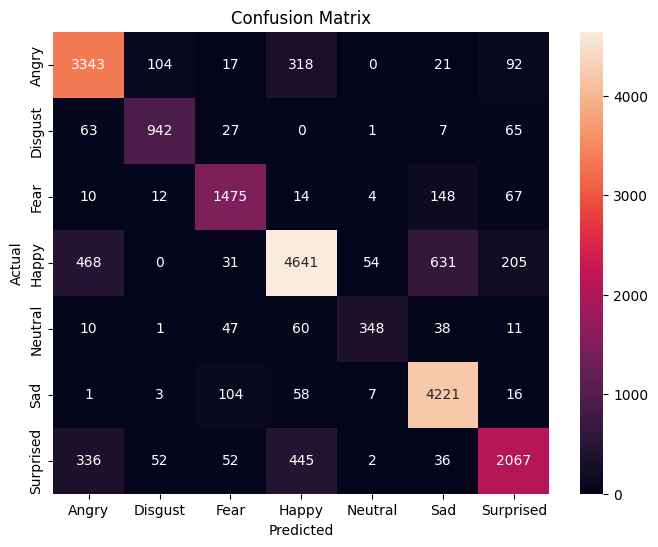

In [22]:
# MULTIMODAL
#confusion matrix and classification report
conf_matrix = confusion_matrix(targetsArr, predictionsArr)

print("\nClassification Report:")
print(classification_report(targetsArr, predictionsArr))
#saves based on modality used
if savingLabel == "MultiModal_EarlyFusion":
    with open(os.path.join(saveResults, "classificationReport_MultiModal_EarlyFusion.txt"), "w") as f:
        f.write(classification_report(targetsArr, predictionsArr))

#visualisation of confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=classNames, yticklabels=classNames)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
#saves based on modality used
if savingLabel == "RGB":
    plt.savefig(os.path.join(saveResults, "confusionMatrix_MultiModal_EarlyFusion.png"))
plt.show()

In [ ]:
#visualising some images and their labels

#true images and labels
imagesPlot, labelsPlot = next(iter(train_loader))

fig = plt.figure(figsize=(10, 8))
for i in range(3*3):

    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(np.transpose(torchvision.utils.make_grid(imagesPlot[i].cpu(), normalize=True, padding=1).numpy(), (1, 2, 0)))
    ax.set_title(classNames[labelsPlot[i]])
    ax.axis('off')
    plt.suptitle('Sample Training Images with True Labels',fontsize=14)
plt.tight_layout()


#predicted images and labels
imagesPlotPred, labelsPlotPred = next(iter(test_loader))

fig = plt.figure(figsize=(10, 8))
for i in range(3*3):

    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(np.transpose(torchvision.utils.make_grid(imagesPlotPred[i].cpu(), normalize=True, padding=1).numpy(), (1, 2, 0)))

    trueLabel = classNames[labelsPlotPred[i]]
    predictedLabel = classNames[predicted[i]]

    ax.set_title(f'True: {trueLabel}\nPredicted: {predictedLabel}')
    ax.axis("off")
    plt.suptitle('Sample Testing Images with True and Predicted Labels',fontsize=14)
plt.tight_layout()